In [44]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
)
from ripple_heterogeneity.readout import pairwise_ccgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from sklearn.linear_model import LinearRegression
from statannotations.Annotator import Annotator

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

# locate sessions

In [2]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
105,Z:\Data\FujisawaS\EE\EE0705fm
106,Z:\Data\FujisawaS\EE\EE0706fm
107,Z:\Data\FujisawaS\EE\EE0708fm
108,Z:\Data\HMC1\day12


## Main analysis

In [5]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccgs_readout_v5"
    )

batch_analysis.run(
    df_sessions,
    save_path,
    pairwise_ccgs.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    skip_if_error=False,
)
# load results
label_df, ccgs = pairwise_ccgs.load_results(save_path,verbose=False)

100%|██████████| 110/110 [00:04<00:00, 24.37it/s]


## add cross region labels

In [6]:
label_df.loc[label_df.target_region.str.contains("PFC|MEC"),"deepSuperficial_target"] = "Unknown"
label_df.loc[label_df.ref_region.str.contains("PFC|MEC"),"deepSuperficial_ref"] = "Unknown"

label_df["label"] = label_df.ref_region + "_" + label_df.target_region
label_df["label"] = label_df.label.replace({"MEC_CA1":"CA1_MEC", "PFC_CA1":"CA1_PFC"})

label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_ref == "Deep"),"label"] = "deep_mec"
label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_ref == "Superficial"),"label"] = "sup_mec"

label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_target == "Deep"),"label"] = "deep_mec"
label_df.loc[(label_df.label == "CA1_MEC") & (label_df.deepSuperficial_target == "Superficial"),"label"] = "sup_mec"


label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_ref == "Deep"),"label"] = "deep_pfc"
label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_ref == "Superficial"),"label"] = "sup_pfc"

label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_target == "Deep"),"label"] = "deep_pfc"
label_df.loc[(label_df.label == "CA1_PFC") & (label_df.deepSuperficial_target == "Superficial"),"label"] = "sup_pfc"

label_df.label.unique()

array(['deep_mec', 'sup_mec', 'sup_pfc', 'deep_pfc'], dtype=object)

## compare the spatial correlation during the task with the temporal correlation in post task ripples 

In [41]:
score_task_post = []
label = []
basepaths = []
score_task_pre = []
for basepath in label_df.basepath.unique():
    basepath_idx = label_df.basepath == basepath
    for cross_label_i, cross_label in enumerate(label_df[basepath_idx].label.unique()):

        cross_label_idx = label_df.label == cross_label

        label_df_temp = label_df[cross_label_idx & basepath_idx]

        idx = (
            (label_df_temp.query("epoch == 'task'").peak_rate_ref.values > 1)
            & (label_df_temp.query("epoch == 'task'").peak_rate_tar.values > 1)
            & (label_df_temp.query("epoch == 'task'").n_spikes_ref.values > 100)
            & (label_df_temp.query("epoch == 'task'").n_spikes_tar.values > 100)
            & (label_df_temp.query("epoch == 'post'").n_spikes_ref.values > 100)
            & (label_df_temp.query("epoch == 'post'").n_spikes_tar.values > 100)
        )
        X, y = (
            label_df_temp.query("epoch == 'task'").spatial_corr[idx].values,
            label_df_temp.query("epoch == 'post'").corr_pearson[idx].values,
        )
        if len(y) < 5:
            continue
        good_idx = ~np.isnan(X) & ~np.isnan(y)
        X, y = X[good_idx], y[good_idx]
        reg_task_post = LinearRegression().fit(X.reshape(-1, 1), y)
        score_task_post.append(reg_task_post.score(X.reshape(-1, 1), y))

        X, y = (
            label_df_temp.query("epoch == 'task'").spatial_corr[idx].values,
            label_df_temp.query("epoch == 'pre'").corr_pearson[idx].values,
        )
        good_idx = ~np.isnan(X) & ~np.isnan(y)
        X, y = X[good_idx], y[good_idx]
        reg_task_pre = LinearRegression().fit(X.reshape(-1, 1), y)

        score_task_pre.append(reg_task_pre.score(X.reshape(-1, 1), y))
        label.append(cross_label)
        basepaths.append(basepath)

df = pd.DataFrame(
    {
        "score_task_post": score_task_post,
        "score_task_pre": score_task_pre,
        "label": label,
        "basepath": basepaths,
    }
)


In [42]:
# df["score_pre_post_ratio"] = (df.score_task_post - df.score_task_pre) / (df.score_task_post + df.score_task_pre)
df["score_pre_post_ratio"] = (df.score_task_post / df.score_task_pre)


(<AxesSubplot:xlabel='label', ylabel='score_pre_post_ratio'>,
  <statannotations.Annotation.Annotation at 0x275373671c0>])

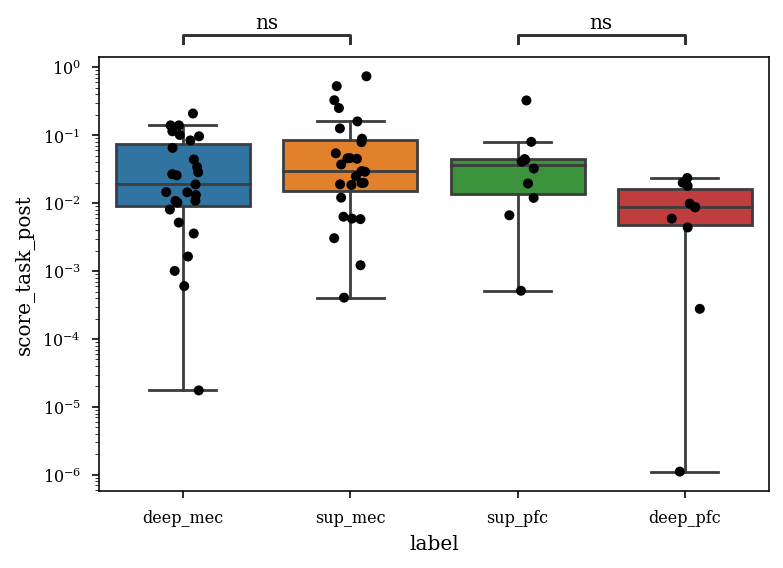

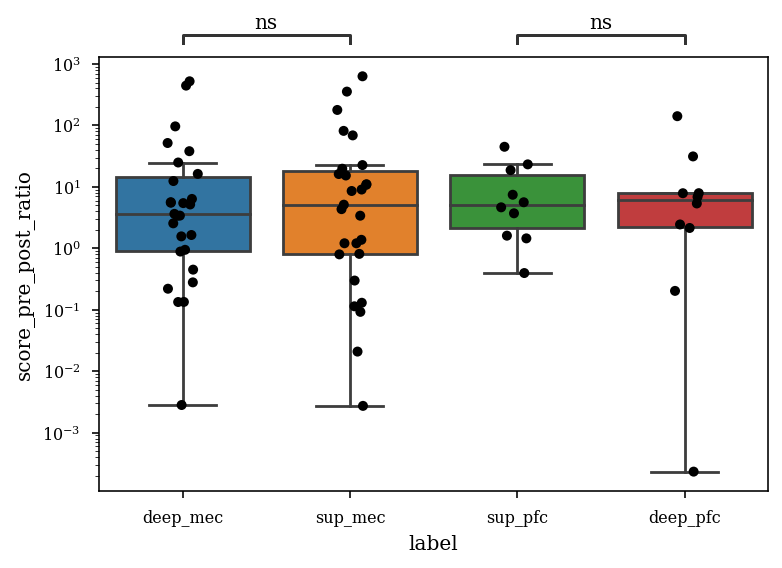

In [48]:
plt.figure()
sns.boxplot(data=df, x="label", y="score_task_post",showfliers=False)
sns.stripplot(data=df, x="label", y="score_task_post",jitter=True,color="k")
plt.yscale("log")

box_pairs = [
    ("sup_mec", "deep_mec"),("sup_pfc", "deep_pfc")
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df,
    x="label",
    y="score_task_post",
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

plt.figure()
sns.boxplot(data=df, x="label", y="score_pre_post_ratio",showfliers=False)
sns.stripplot(data=df, x="label", y="score_pre_post_ratio",jitter=True,color="k")
plt.yscale("log")

box_pairs = [
    ("sup_mec", "deep_mec"),("sup_pfc", "deep_pfc")
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=df,
    x="label",
    y="score_pre_post_ratio",
)
annotator.configure(
    test="t-test_ind",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()

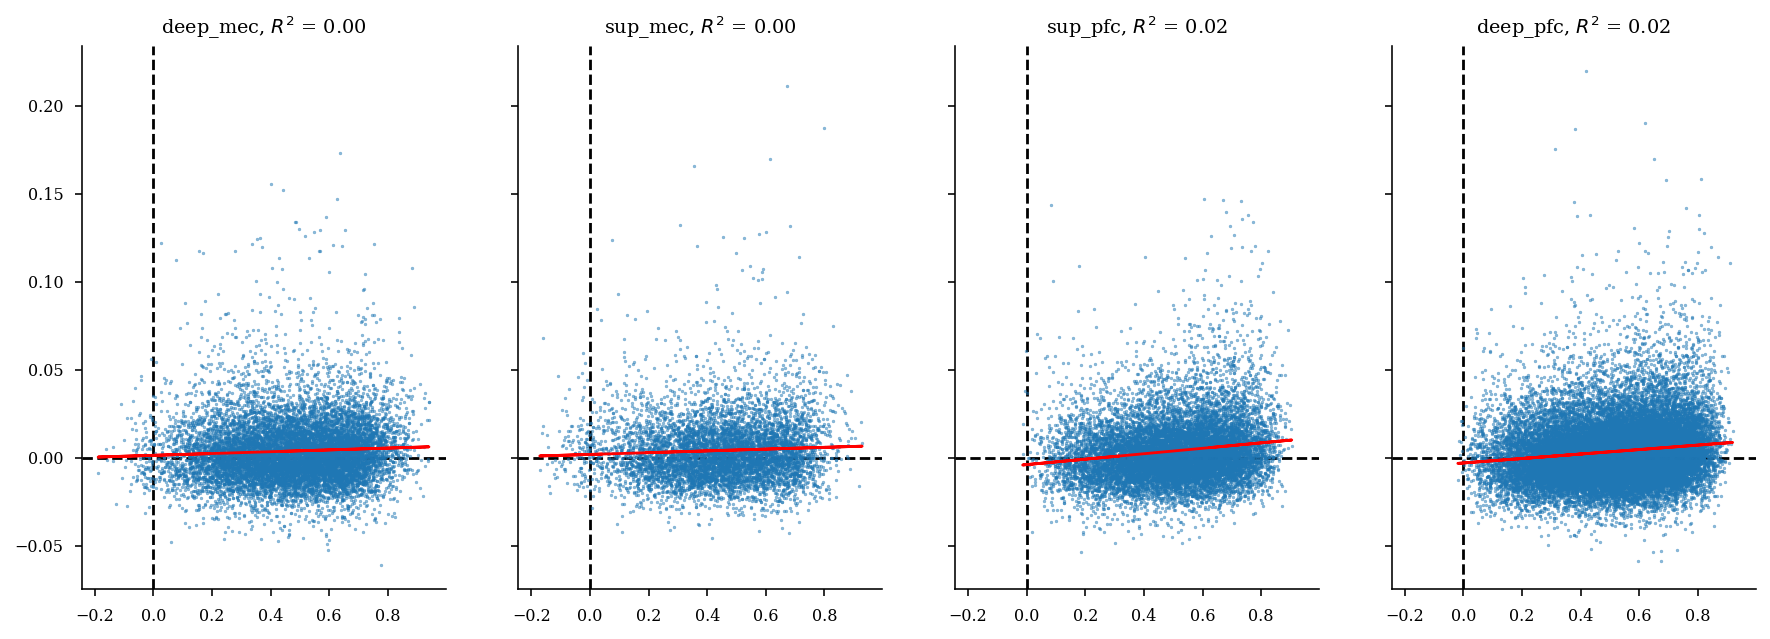

In [320]:
fig,ax = plt.subplots(1,4,figsize=(15,5),sharey=True,sharex=True)
for cross_label_i, cross_label in enumerate(label_df.label.unique()):
    label_df_temp = label_df.query(f"label == '{cross_label}'")
    idx = (
        (label_df_temp.query("epoch == 'task'").peak_rate_ref.values > 1)
        & (label_df_temp.query("epoch == 'task'").peak_rate_tar.values > 1)
        & (label_df_temp.query("epoch == 'task'").n_spikes_ref.values > 100)
        & (label_df_temp.query("epoch == 'task'").n_spikes_tar.values > 100)
        & (label_df_temp.query("epoch == 'post'").n_spikes_ref.values > 100)
        & (label_df_temp.query("epoch == 'post'").n_spikes_tar.values > 100)
    )
    X, y = (
        label_df_temp.query("epoch == 'task'").spatial_corr[idx].values,
        label_df_temp.query("epoch == 'post'").corr_pearson[idx].values,
    )
    good_idx = ~np.isnan(X) & ~np.isnan(y)
    X, y = X[good_idx], y[good_idx]
    reg = LinearRegression().fit(X.reshape(-1, 1), y)
    ax[cross_label_i].scatter(X, y, alpha=0.5,s=2)
    ax[cross_label_i].plot(X,reg.coef_*X + reg.intercept_, color="r")
    ax[cross_label_i].set_title(F"{cross_label}, $R^2$ = {reg.score(X.reshape(-1, 1),y):.2f}")
    ax[cross_label_i].axvline(0, color="black", linestyle="--",zorder=-1000)
    ax[cross_label_i].axhline(0, color="black", linestyle="--",zorder=-1000)

sns.despine()

In [204]:
label_df

,corr_pearson,pval_pearson,corr_spearman,pval_spearman,spatial_corr,spatial_info_ref,spatial_info_tar,peak_rate_ref,peak_rate_tar,n_spikes_ref,...,target_UID,ref_region,target_region,ref_id,target_id,epoch,environment,basepath,label,unique_id
0,-0.006506,0.617663,-0.006980,0.592304,NaN,NaN,NaN,NaN,NaN,113,...,87,CA1,MEC,0,16,pre,sleep,Z:\Data\AYAold\AYA7\day19,deep_mec,Z:\Data\AYAold\AYA7\day19_59_87
1,0.011200,0.390156,0.018626,0.152958,NaN,NaN,NaN,NaN,NaN,113,...,89,CA1,MEC,0,17,pre,sleep,Z:\Data\AYAold\AYA7\day19,deep_mec,Z:\Data\AYAold\AYA7\day19_59_89
2,-0.002054,0.874766,-0.002204,0.865734,NaN,NaN,NaN,NaN,NaN,113,...,90,CA1,MEC,0,18,pre,sleep,Z:\Data\AYAold\AYA7\day19,deep_mec,Z:\Data\AYAold\AYA7\day19_59_90
3,0.012423,0.340521,0.021058,0.106135,NaN,NaN,NaN,NaN,NaN,113,...,91,CA1,MEC,0,19,pre,sleep,Z:\Data\AYAold\AYA7\day19,deep_mec,Z:\Data\AYAold\AYA7\day19_59_91
4,-0.007703,0.554503,-0.008264,0.526049,NaN,NaN,NaN,NaN,NaN,113,...,92,CA1,MEC,0,20,pre,sleep,Z:\Data\AYAold\AYA7\day19,deep_mec,Z:\Data\AYAold\AYA7\day19_59_92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229867,0.019082,0.204108,0.014712,0.327521,NaN,NaN,NaN,NaN,NaN,93,...,41,PFC,CA1,13,26,post,sleep,Z:\Data\ORproject\OR18\day2,sup_pfc,Z:\Data\ORproject\OR18\day2_21_41
229868,0.000057,0.996969,-0.004189,0.780445,NaN,NaN,NaN,NaN,NaN,93,...,44,PFC,CA1,13,27,post,sleep,Z:\Data\ORproject\OR18\day2,sup_pfc,Z:\Data\ORproject\OR18\day2_21_44
229869,0.017526,0.243468,0.020195,0.178937,NaN,NaN,NaN,NaN,NaN,93,...,46,PFC,CA1,13,29,post,sleep,Z:\Data\ORproject\OR18\day2,deep_pfc,Z:\Data\ORproject\OR18\day2_21_46
229870,0.014250,0.342972,0.020400,0.174551,NaN,NaN,NaN,NaN,NaN,93,...,47,PFC,CA1,13,30,post,sleep,Z:\Data\ORproject\OR18\day2,sup_pfc,Z:\Data\ORproject\OR18\day2_21_47


In [261]:
idx = (
    ((label_df.peak_rate_ref > 1) | np.isnan(label_df.peak_rate_ref))
    & ((label_df.peak_rate_tar > 1) | np.isnan(label_df.peak_rate_tar))
    & (label_df.n_spikes_ref > 100)
    & (label_df.n_spikes_tar > 100)
).values


In [270]:
label_df["unique_id"] = label_df.basepath + "_" + label_df.ref_UID.astype(str) + "_" + label_df.target_UID.astype(str)

idx = (
    ((label_df.peak_rate_ref > 1) | (label_df.epoch == "post"))
    & ((label_df.peak_rate_tar > 1) | (label_df.epoch == "post"))
    & (label_df.n_spikes_ref > 100)
    & (label_df.n_spikes_tar > 100)
).values

label_df_pivot = label_df[idx].pivot(index=["unique_id"], columns=["epoch","label"], values=["corr_pearson","spatial_corr"]).reset_index()
# label_df_pivot
# plt.hist(label_df.query("epoch == 'post'").corr_pearson.values - label_df.query("epoch == 'task'").spatial_corr.values,100)
# plt.show()
label_df_pivot

unique_id corr_pearson                           \
epoch                                           task             post           
label                                       deep_mec sup_mec deep_mec sup_mec   
0       Z:\Data\AYAold\AYA7\day19_59_90     0.007712     NaN      NaN     NaN   
1       Z:\Data\AYAold\AYA7\day19_59_92    -0.012609     NaN      NaN     NaN   
2       Z:\Data\AYAold\AYA7\day19_59_93    -0.023789     NaN      NaN     NaN   
3       Z:\Data\AYAold\AYA7\day19_59_97    -0.002853     NaN      NaN     NaN   
4       Z:\Data\AYAold\AYA7\day19_60_90    -0.009859     NaN      NaN     NaN   
...                                 ...          ...     ...      ...     ...   
71842  Z:\Data\ORproject\OR18\day2_9_41          NaN     NaN      NaN     NaN   
71843  Z:\Data\ORproject\OR18\day2_9_44          NaN     NaN      NaN     NaN   
71844  Z:\Data\ORproject\OR18\day2_9_46          NaN     NaN      NaN     NaN   
71845  Z:\Data\ORproject\OR18\day2_9_47          NaN     NaN      NaN     NaN   
71846  Z:\Data\ORproject\OR18\day2_9_49          NaN     NaN      NaN     NaN   

                                              spatial_corr                   \
epoch      task                post                   task             post   
label   sup_pfc  deep_pfc   sup_pfc  deep_pfc     deep_mec sup_mec deep_mec   
0           NaN       NaN       NaN       NaN     0.320136     NaN      NaN   
1           NaN       NaN       NaN       NaN     0.243330     NaN      NaN   
2           NaN       NaN       NaN       NaN     0.177928     NaN      NaN   
3           NaN       NaN       NaN       NaN     0.121755     NaN      NaN   
4           NaN       NaN       NaN       NaN     0.548042     NaN      NaN   
...         ...       ...       ...       ...          ...     ...      ...   
71842 -0.019788       NaN  0.009939       NaN          NaN     NaN      NaN   
71843  0.027437       NaN  0.028952       NaN          NaN     NaN      NaN   
71844       NaN  0.017488       NaN  0.009682          NaN     NaN      NaN   
71845       NaN       NaN  0.020411       NaN          NaN     NaN      NaN   
71846       NaN  0.023828       NaN  0.006692          NaN     NaN      NaN   

                                                    
epoch              task              post           
label sup_mec   sup_pfc  deep_pfc sup_pfc deep_pfc  
0         NaN       NaN       NaN     NaN      NaN  
1         NaN       NaN       NaN     NaN      NaN  
2         NaN       NaN       NaN     NaN      NaN  
3         NaN       NaN       NaN     NaN      NaN  
4         NaN       NaN       NaN     NaN      NaN  
...       ...       ...       ...     ...      ...  
71842     NaN  0.697116       NaN     NaN      NaN  
71843     NaN  0.713291       NaN     NaN      NaN  
71844     NaN       NaN  0.582640     NaN      NaN  
71845     NaN       NaN       NaN     NaN      NaN  
71846     NaN       NaN  0.238661     NaN      NaN  

[71847 rows x 17 columns]

In [271]:
ratio_df_wide = (
    (label_df_pivot["corr_pearson"]["post"] + 1)
    - (label_df_pivot["spatial_corr"]["task"] + 1)
) / (
    (label_df_pivot["corr_pearson"]["post"] + 1)
    + (label_df_pivot["spatial_corr"]["task"] + 1)
)

# ratio_df_wide = (
#     np.abs(label_df_pivot["corr_pearson"]["post"]) / np.abs(label_df_pivot["spatial_corr"]["task"])
# )

# ratio_df_wide = (
#     (label_df_pivot["corr_pearson"]["post"])**2 - (label_df_pivot["spatial_corr"]["task"])**2
# )
ratio_df_long = pd.DataFrame()
ratio_df_long["ratio"] = pd.concat(
    [
        ratio_df_wide.deep_mec,
        ratio_df_wide.sup_mec,
        ratio_df_wide.deep_pfc,
        ratio_df_wide.sup_pfc,
    ],
    ignore_index=True,
)
ratio_df_long["label"] = np.hstack(
    [
        ["deep_mec"] * ratio_df_wide.shape[0],
        ["sup_mec"] * ratio_df_wide.shape[0],
        ["deep_pfc"] * ratio_df_wide.shape[0],
        ["sup_pfc"] * ratio_df_wide.shape[0],
    ]
)
ratio_df_long


,ratio,label
0,NaN,deep_mec
1,NaN,deep_mec
2,NaN,deep_mec
3,NaN,deep_mec
4,NaN,deep_mec
...,...,...
287383,-0.253847,sup_pfc
287384,-0.249554,sup_pfc
287385,NaN,sup_pfc
287386,NaN,sup_pfc


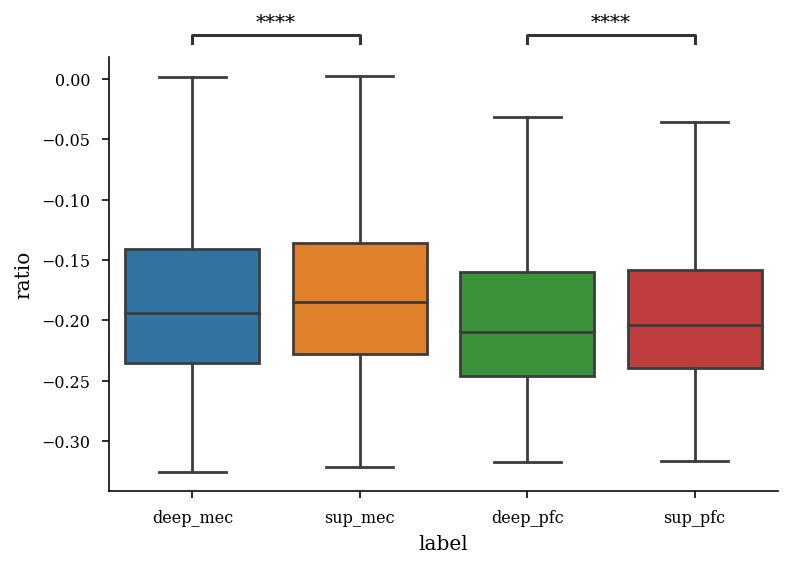

In [272]:
sns.boxplot(data=ratio_df_long, x="label", y="ratio",showfliers=False)
# plt.axhline(0, color="black", linestyle="--",zorder=-1000)
box_pairs = [
    ("sup_mec", "deep_mec"),("sup_pfc", "deep_pfc")
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=ratio_df_long,
    x="label",
    y="ratio",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=0,
)
annotator.apply_and_annotate()
sns.despine()

## compare just temporal correlations

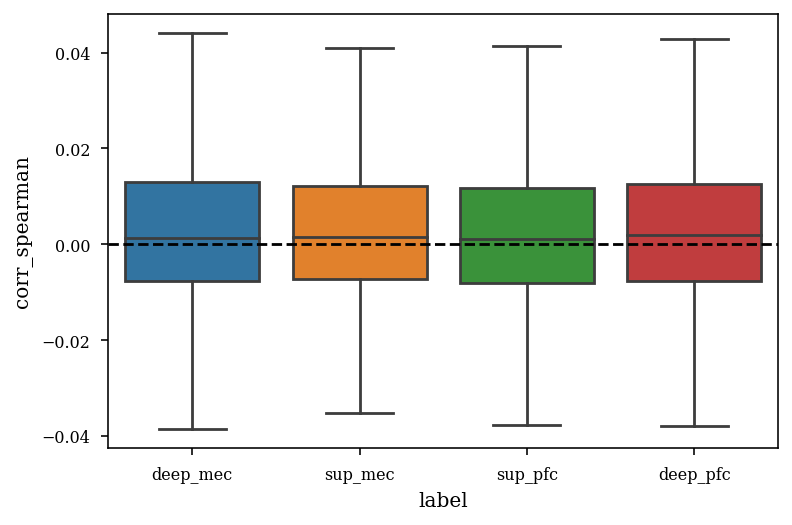

<AxesSubplot:xlabel='label', ylabel='corr_spearman_abs'>

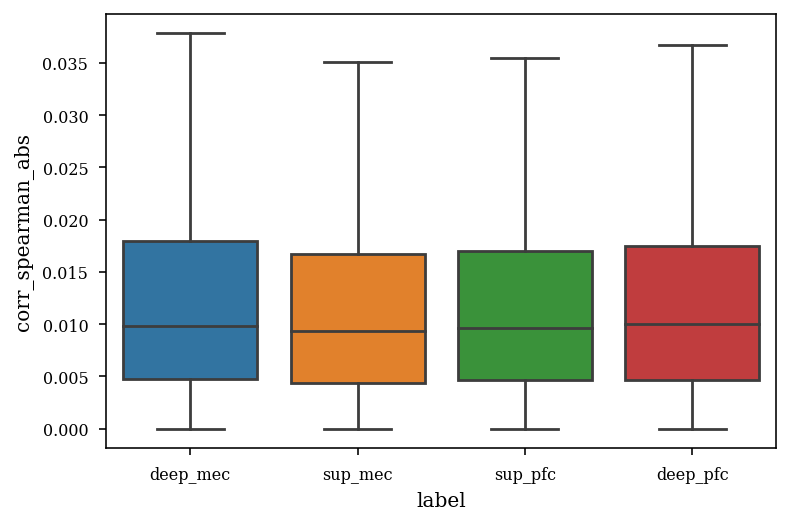

In [250]:
sns.boxplot(x="label",y="corr_spearman",data=label_df.query("epoch == 'post'"),showfliers=False)
plt.axhline(0,color="black",linestyle="--")
plt.show()

label_df["corr_spearman_abs"] = np.abs(label_df["corr_spearman"])
sns.boxplot(x="label",y="corr_spearman_abs",data=label_df.query("epoch == 'post'"),showfliers=False)
# plt.axhline(0,color="black",linestyle="--")

In [211]:
label_df["unique_id"] = label_df.basepath + "_" + label_df.ref_UID.astype(str) + "_" + label_df.target_UID.astype(str)

label_df_pivot = label_df.pivot(index=["unique_id"], columns=["epoch","label"], values="corr_spearman").reset_index()
label_df_pivot

epoch                         unique_id       pre              task          \
label                                    deep_mec sup_mec  deep_mec sup_mec   
0       Z:\Data\AYAold\AYA7\day19_59_87 -0.006980     NaN -0.006725     NaN   
1       Z:\Data\AYAold\AYA7\day19_59_89  0.018626     NaN -0.009094     NaN   
2       Z:\Data\AYAold\AYA7\day19_59_90 -0.002204     NaN  0.006222     NaN   
3       Z:\Data\AYAold\AYA7\day19_59_91  0.021058     NaN -0.001875     NaN   
4       Z:\Data\AYAold\AYA7\day19_59_92 -0.008264     NaN -0.014018     NaN   
...                                 ...       ...     ...       ...     ...   
76619  Z:\Data\ORproject\OR18\day2_9_41       NaN     NaN       NaN     NaN   
76620  Z:\Data\ORproject\OR18\day2_9_44       NaN     NaN       NaN     NaN   
76621  Z:\Data\ORproject\OR18\day2_9_46       NaN     NaN       NaN     NaN   
76622  Z:\Data\ORproject\OR18\day2_9_47       NaN     NaN       NaN     NaN   
76623  Z:\Data\ORproject\OR18\day2_9_49       NaN     NaN       NaN     NaN   

epoch      post               pre                task                post  \
label  deep_mec sup_mec   sup_pfc  deep_pfc   sup_pfc  deep_pfc   sup_pfc   
0     -0.009888     NaN       NaN       NaN       NaN       NaN       NaN   
1      0.009307     NaN       NaN       NaN       NaN       NaN       NaN   
2     -0.008258     NaN       NaN       NaN       NaN       NaN       NaN   
3     -0.004767     NaN       NaN       NaN       NaN       NaN       NaN   
4      0.000010     NaN       NaN       NaN       NaN       NaN       NaN   
...         ...     ...       ...       ...       ...       ...       ...   
76619       NaN     NaN  0.001426       NaN -0.017165       NaN  0.022630   
76620       NaN     NaN  0.002625       NaN  0.025565       NaN  0.016835   
76621       NaN     NaN       NaN  0.000640       NaN  0.017421       NaN   
76622       NaN     NaN  0.006414       NaN  0.014495       NaN  0.023923   
76623       NaN     NaN       NaN -0.007559       NaN  0.024294       NaN   

epoch            
label  deep_pfc  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
76619       NaN  
76620       NaN  
76621  0.019365  
76622       NaN  
76623  0.013645  

[76624 rows x 13 columns]

In [138]:
# ratio_df_wide = (label_df_pivot["post"] - label_df_pivot["task"]) / (label_df_pivot["post"] + label_df_pivot["task"])
# ratio_df_wide = (np.abs(label_df_pivot["post"]) - np.abs(label_df_pivot["task"])) / (np.abs(label_df_pivot["post"]) + np.abs(label_df_pivot["task"]))
ratio_df_wide = ((label_df_pivot["post"]+1) - (label_df_pivot["task"]+1)) / ((label_df_pivot["post"]+1) + (label_df_pivot["task"]+1))

ratio_df_long = pd.DataFrame()
ratio_df_long["ratio"] = pd.concat(
    [
        ratio_df_wide.deep_mec,
        ratio_df_wide.sup_mec,
        ratio_df_wide.deep_pfc,
        ratio_df_wide.sup_pfc,
    ],
    ignore_index=True,
)
ratio_df_long["label"] = np.hstack(
    [
        ["deep_mec"] * ratio_df_wide.shape[0],
        ["sup_mec"] * ratio_df_wide.shape[0],
        ["deep_pfc"] * ratio_df_wide.shape[0],
        ["sup_pfc"] * ratio_df_wide.shape[0],
    ]
)
ratio_df_long

,ratio,label
0,-0.001595,deep_mec
1,0.009200,deep_mec
2,-0.007248,deep_mec
3,-0.001451,deep_mec
4,0.007064,deep_mec
...,...,...
306491,0.019844,sup_pfc
306492,-0.004274,sup_pfc
306493,NaN,sup_pfc
306494,0.004625,sup_pfc


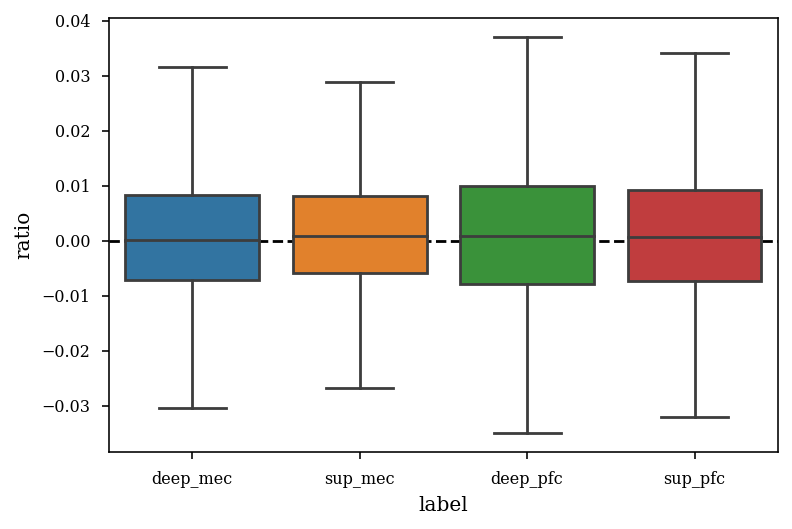

In [140]:
sns.boxplot(data=ratio_df_long, x="label", y="ratio",showfliers=False)
# sns.stripplot(data=ratio_df_long, x="label", y="ratio",jitter=True,color="k")
plt.axhline(0, color="black", linestyle="--",zorder=-1000)

## visualize ccgs

by sorting by the spatial correlations in the task, one would hope post task ripple ccgs would differ 

This does not seem to be the case.

In [124]:
# corr_ratio = []
# label = []
# for cross_label_i, cross_label in enumerate(label_df.label.unique()):
#     corr_pre.append(label_df.query(f"epoch == 'pre' & label == '{cross_label}'").corr_pearson.values)
#     corr_task.append(label_df.query(f"epoch == 'task' & label == '{cross_label}'").corr_pearson.values)
#     corr_task.append(label_df.query(f"epoch == 'post' & label == '{cross_label}'").corr_pearson.values)

        
#     label.append([cross_label]*len(corr_ratio[-1]))

# df = pd.DataFrame(
#     {
#         "corr_ratio": corr_ratio,
#         "label": label,
#         "basepath": basepaths,
#     }
# )


<AxesSubplot:>

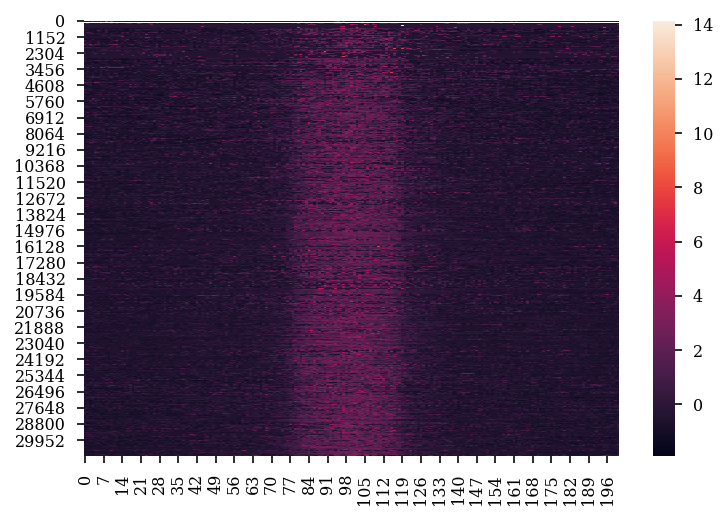

In [186]:
sns.heatmap(stats.zscore(psth_smooth, axis=0).T)

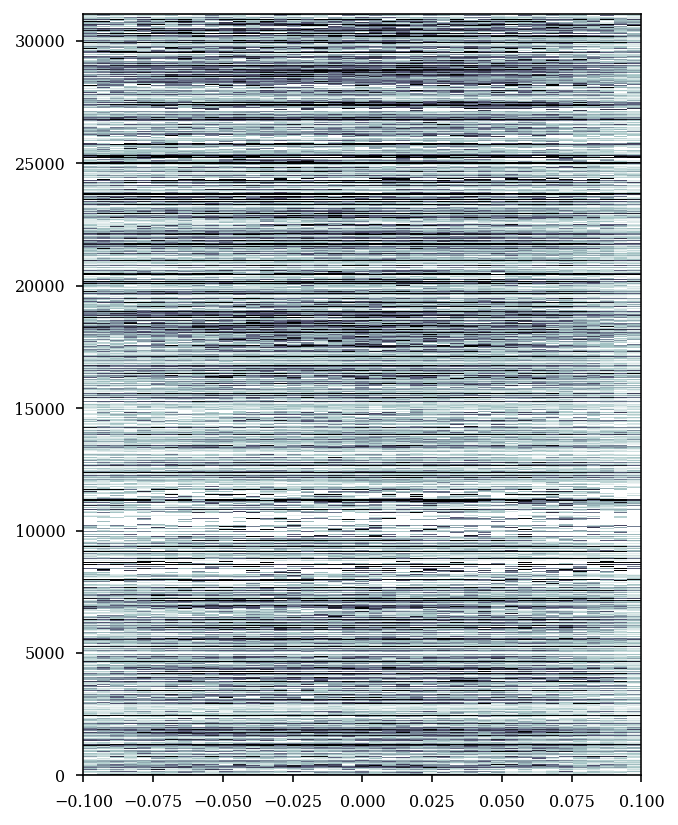

In [201]:
from scipy.ndimage import gaussian_filter1d

idx = ((label_df.epoch == "post") & (label_df.label == "deep_pfc")).values
ccgs_task = ccgs.iloc[:,idx]
ccgs_task = ccgs_task.loc[(ccgs_task.index >=-.1) & (ccgs_task.index <=.1),:]

sort_idx = np.argsort(label_df[idx].spatial_corr.values)
extent = [ccgs_task.index.min(), ccgs_task.index.max(), 0, ccgs_task.shape[1]]
vmax=3
vmin=-3

# psth_smooth = gaussian_filter1d(
#     ccgs_task.values, np.round(0.020 / np.diff(ccgs_task.index)[0]), axis=0
# )
psth_smooth = ccgs_task.values
# max_mean_ratio = psth_smooth[(ccgs_task.index > 0) & (ccgs_task.index < 0.1), :].max(
#     axis=0
# ) / psth_smooth[(ccgs_task.index < -0.10), :].mean(axis=0)

# sort_idx = np.argsort(max_mean_ratio)
    # stats.zscore(psth_smooth, axis=0)[:, sort_idx].T,

plt.figure(figsize=(5, 7))
plt.imshow(
    psth_smooth[:, sort_idx].T,
    aspect="auto",
    interpolation="nearest",
    extent=extent,
    vmin=0,
    vmax=6,
    cmap="bone_r",
)
# sns.heatmap(ccgs.iloc[:,np.argsort(label_df.spatial_corr)].T)

C:\Users\Cornell\AppData\Local\Temp\ipykernel_20760\2993417489.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Cornell\AppData\Local\Temp\ipykernel_20760\2993417489.py:18: RuntimeWarning: invalid value encountered in true_divide


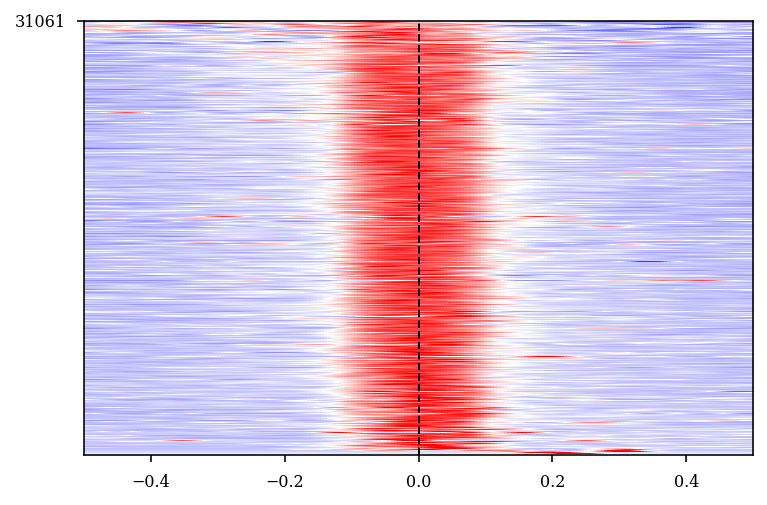

In [179]:
plot_psth_matrix(ccgs_task)


In [173]:
from scipy.ndimage import gaussian_filter1d


def plot_psth_matrix(
    psth_df, label=None, ax=None, vmax=3, vmin=-3,smoothing=True
):

    psth = psth_df.values
    
    psth = psth[:,~np.isnan(psth).any(axis=0)]
    if smoothing:
        psth_smooth = gaussian_filter1d(
            psth, np.round(0.020 / np.diff(psth_df.index)[0]), axis=0
        )
    else:
        psth_smooth = psth
    # psth_smooth = psth
    max_mean_ratio = psth_smooth[(psth_df.index > 0) & (psth_df.index < 0.1), :].max(
        axis=0
    ) / psth_smooth[(psth_df.index < -0.10), :].mean(axis=0)

    sort_idx = np.argsort(max_mean_ratio)

    if ax is None:
        plt.figure()
    ax = plt.gca()

    extent = [psth_df.index.min(), psth_df.index.max(), 0, psth.shape[1]]

    sm = ax.imshow(
        stats.zscore(psth_smooth, axis=0)[:, sort_idx].T,
        aspect="auto",
        interpolation="nearest",
        extent=extent,
        vmin=vmin,
        vmax=vmax,
        cmap="bwr",
    )

    ax.set_yticks([psth.shape[1]])

    ax.axvline(0, color="k", lw=1, ls="--")
    if label is not None:
        ax.set_title(label, fontsize=12)
    return sm
    
def confidence_intervals(X,conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X),axis=1) == 0,:]
    # compute interval for each column
    interval = [stats.t.interval(conf, len(a) - 1, loc = np.mean(a), scale = stats.sem(a)) for a in X.T]
    interval = np.vstack(interval)
    lower = interval[:,0]
    upper = interval[:,1]
    return lower,upper
    
def std_upper_lower(X):
    upper = np.nanmean(X,axis=1) + np.nanstd(X,axis=1)
    lower = np.nanmean(X,axis=1) - np.nanstd(X,axis=1)
    return lower,upper

def get_center_val(psth_df, window=[0,0.05], smooth_sigma=0.02):
    # find cells within region
    psth = psth_df.values
    # standardize psth
    psth = stats.zscore(psth, axis=0)
    # smooth over time
    psth_smooth = gaussian_filter1d(
        psth, np.round(smooth_sigma / np.diff(psth_df.index)[0]), axis=0
    )
    # pull out data within time window
    X = psth_smooth[(psth_df.index > window[0]) & (psth_df.index < window[1]), :]
    # find center value of each cell, can be positive or negative, but will be max magnitude
    center_val = [X[np.argmax(np.abs(X[:,i])),i] for i in range(X.shape[1])]
    return np.array(center_val)

def plot_psth_postive_negative(psth_df, group_label, group_colors, ax0):

    center_val = get_center_val(psth_df)

    # plot positive psth responses
    psth = psth_df.values
    psth = psth[:,center_val > 0]
    psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)

    # plot negative psth responses
    psth = psth_df.values
    psth = psth[:,center_val < 0]
    psth = stats.zscore(psth, axis=0)
    lower,upper= confidence_intervals(psth.T)
    ax0.plot(psth_df.index,np.nanmean(psth,axis=1),color=group_colors[group_label],linewidth=1)
    ax0.fill_between(psth_df.index, lower, upper, color=group_colors[group_label], alpha = .5, linewidth = 0)



C:\Users\Cornell\AppData\Local\Temp\ipykernel_20760\2993417489.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Cornell\AppData\Local\Temp\ipykernel_20760\2993417489.py:18: RuntimeWarning: invalid value encountered in true_divide


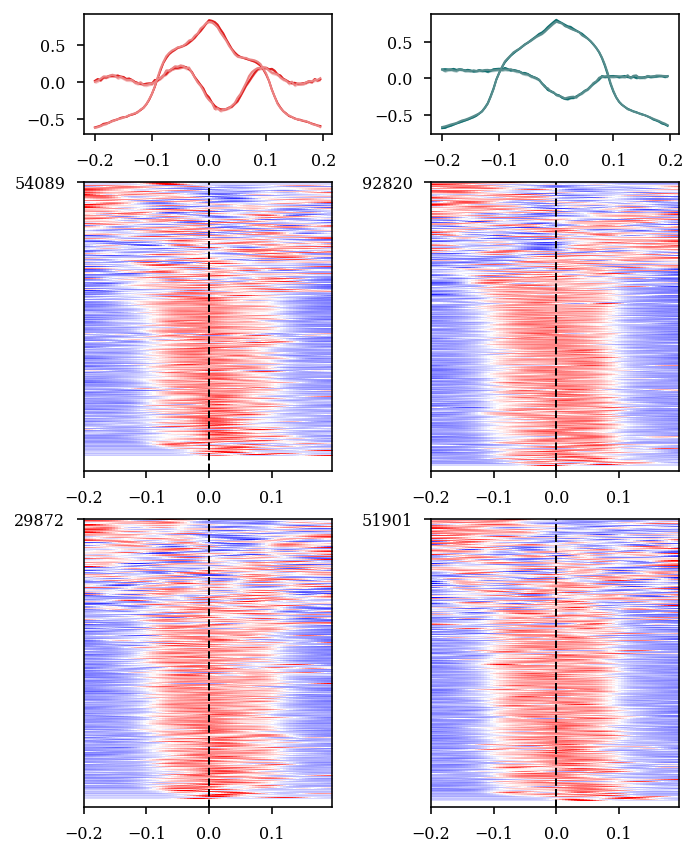

In [174]:
group_colors = {
    "deep_mec": "#de2020",
    "sup_mec": "#eb8383",
    "deep_pfc": "#116f70",
    "sup_pfc": "#568c8c",
}
ccgs_restrict = ccgs.loc[(ccgs.index >=-.2) & (ccgs.index <=.2),:]

fig = plt.figure(figsize=functions.set_size('thesis', fraction=1, subplots=(4,2)),constrained_layout=False)
gs = fig.add_gridspec(nrows=5, ncols=2, left=0.05, right=0.75, hspace=0.4, wspace=0.4)

y_min = -.75
y_max = 1.25
heatmap_factor = 2

ax0 = fig.add_subplot(gs[0, 0])
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="deep_mec"], 'deep_mec', group_colors, ax0)
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="sup_mec"], 'sup_mec', group_colors, ax0)


ax1 = fig.add_subplot(gs[0, 1])
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="deep_pfc"], 'deep_pfc', group_colors, ax1)
plot_psth_postive_negative(ccgs_restrict.loc[:,label_df.label=="sup_pfc"], 'sup_pfc', group_colors, ax1)


ax2 = fig.add_subplot(gs[1:3,0])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="deep_mec"], label=None, ax=ax2, vmax=3, vmin=-3)


ax3 = fig.add_subplot(gs[1:3,1])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="deep_pfc"], label=None, ax=ax3, vmax=3, vmin=-3)


ax4 = fig.add_subplot(gs[3:,0])
plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="sup_mec"], label=None, ax=ax4, vmax=3, vmin=-3)

ax5 = fig.add_subplot(gs[3:,1])
sm = plot_psth_matrix(ccgs_restrict.loc[:,label_df.label=="sup_pfc"], label=None, ax=ax5, vmax=3, vmin=-3)

# axs = [ax0,ax1,ax2,ax3,ax4,ax5]
# for i in range(6):
#     axs[i].set_xlim([-0.2,.2])

## testing below

In [12]:
basepath = r"Z:\Data\AYAold\AYA7\day20"
brainRegions="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC"  # brain regions to include

# load in spike data
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion=brainRegions
)

In [34]:
rip_exp_start=0.2
rip_exp_stop=0.2
ripples_df = loading.load_ripples_events(basepath)
ripples = (
    nel.EpochArray(np.array([ripples_df.peaks, ripples_df.peaks]).T)
    .expand(rip_exp_start, direction="start")
    .expand(rip_exp_stop, direction="stop")
)

In [23]:
binsize=0.005
nbins=200

In [35]:
ccgs, pairs = functions.pairwise_cross_corr(
    st[ripples].data, return_index=True, binsize=binsize, nbins=nbins
)

<AxesSubplot:>

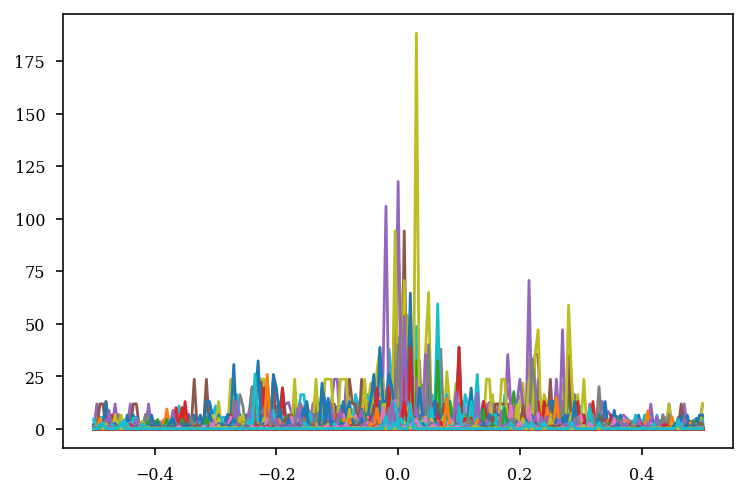

In [36]:
ccgs.plot(legend=False)